## Task 1.1 - Dataset Exploration

### Import necessary libraries

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

import math
import numpy as np
import pandas as pd
import seaborn as sns

import os
import sys
import gdown
import zipfile

sys.path.append("utils")

import helper
import dataset

import importlib
importlib.reload(helper)
importlib.reload(dataset)

from helper import *
from dataset import *

### Load datasets from cloud

In [2]:
data_url = "https://drive.google.com/drive/folders/1MyX__3hRiPkWHGFKqZXpOyq32KQpPDTR?usp=sharing"
gdown.download_folder(data_url, quiet=True)

['c:\\Users\\zainm\\Desktop\\AMLS\\data\\X_train.bin',
 'c:\\Users\\zainm\\Desktop\\AMLS\\data\\X_test.bin',
 'c:\\Users\\zainm\\Desktop\\AMLS\\data\\y_train.csv']

In [3]:
root = os.getcwd()
ecg_data_path = root + '/data/X_train.bin'
labels_path = root + '/data/y_train.csv'

ecg_data = load_data(ecg_data_path, 'rb')
labels = load_data(labels_path, 'r')

In [4]:
df = pd.DataFrame({'Data': ecg_data, 'Label': labels})
df['Length'] = df['Data'].apply(lambda seq: len(seq))
print(f'Number of total data points: {df["Data"].count()}')
df.head()

Number of total data points: 6179


,Data,Label,Length
0,"[-217, -246, -294, -344, -363, -371, -377, -37...",2,9000
1,"[-446, -541, -637, -733, -819, -858, -867, -87...",2,18000
2,"[-440, -527, -614, -698, -770, -790, -796, -79...",2,9000
3,"[-1255, -1488, -1745, -2015, -2253, -2374, -23...",0,9000
4,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ...",0,9000


### Plot some samples

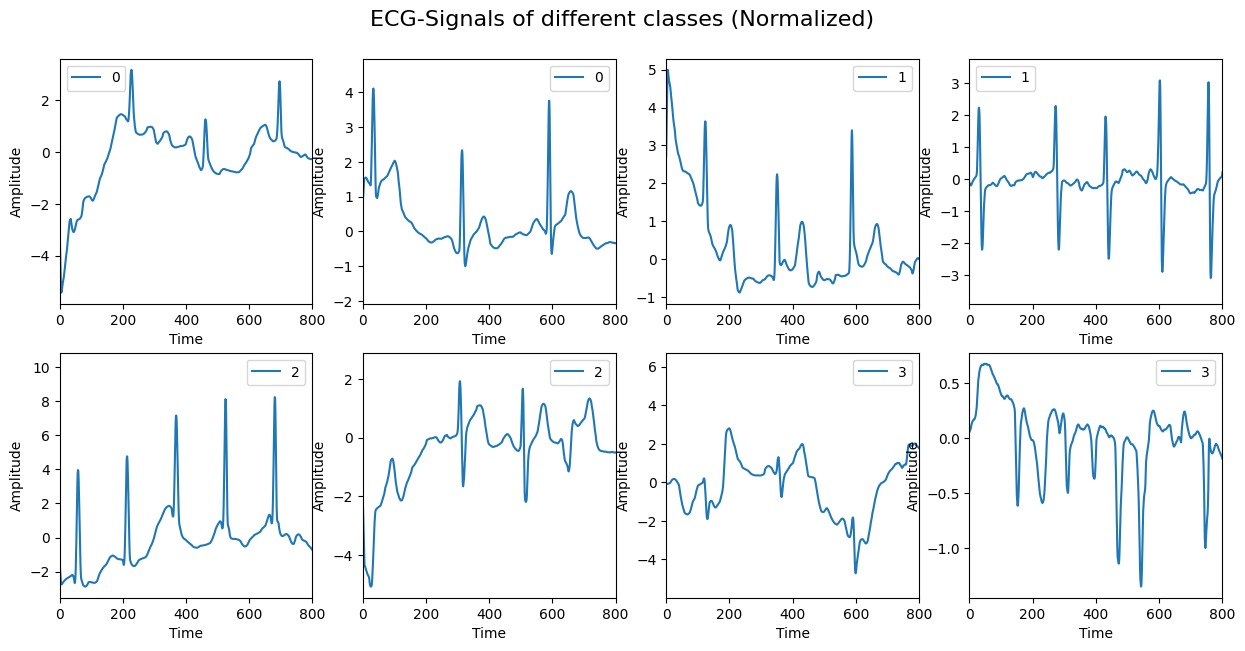

In [5]:
# normalize data points
sequences = df["Data"].to_numpy()
normalized_data = normalize_data(sequences)

# retrieve 2 signals from each class
df_norm = df.copy()
df_norm["Data"] = normalized_data

df_sorted = df_norm.sort_values("Label")
subset = df_sorted.groupby("Label").head(2)
data = subset["Data"].to_numpy()
class_labels = subset["Label"].to_numpy()

plot_signals(
    data, 
    class_labels, 
    num_rows=2, num_cols=4, 
    start_idx=0, total_sequences=8, 
    xlim_right=800
)

### Plot class distributions

Class 0: 3638
Class 1: 549
Class 2: 1765
Class 3: 227


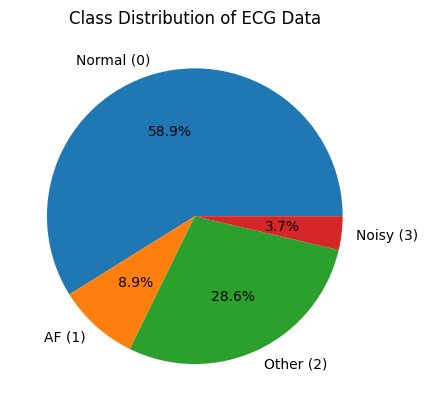

In [6]:
all_classes = ["Normal (0)", "AF (1)", "Other (2)", "Noisy (3)"]

_df = df.groupby('Label').count()
count = _df['Data'].to_numpy()
print(f"Class 0: {count[0]}\nClass 1: {count[1]}\nClass 2: {count[2]}\nClass 3: {count[3]}")

fig, ax = plt.subplots()
ax.pie(count, labels=all_classes, autopct='%1.1f%%')
plt.title('Class Distribution of ECG Data')
plt.show()

### Analyze lengths of the samples

Number of all different lengths: 1082

--- All Lengths ---
Min Length: 2714
Max Length: 18286
Avg. Length: 8638.57
Most Frequent Length: 9000 with 4341 occurences

--- Class dependant Lengths ---
Class 0  --  Min-Length: 2714  -  Max-Length: 18286  -  Avg-Length: 9662
Class 1  --  Min-Length: 2996  -  Max-Length: 18062  -  Avg-Length: 9510
Class 2  --  Min-Length: 2738  -  Max-Length: 18188  -  Avg-Length: 10366
Class 3  --  Min-Length: 2808  -  Max-Length: 18000  -  Avg-Length: 7210


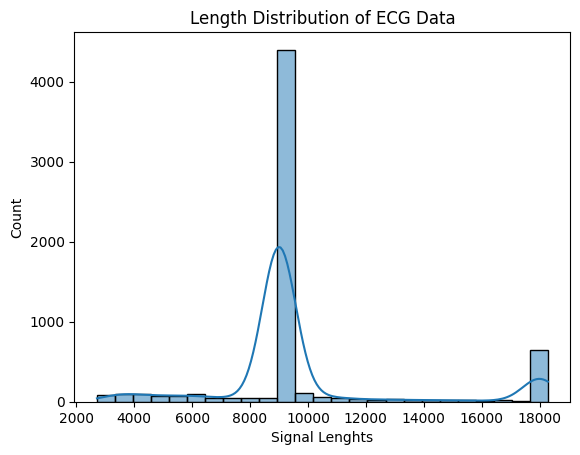

In [7]:
lengths = df["Length"].to_numpy()
unique_lengths, counts = np.unique(lengths, return_counts=True)
min_val = unique_lengths.min()
max_val = unique_lengths.max()
mean_val = unique_lengths.mean()
most_frequent_length = unique_lengths[np.argmax(counts)]

# print(np.max(counts), counts[np.argmax(counts)])

print(f'Number of all different lengths: {len(unique_lengths)}\n')
print("--- All Lengths ---")
print(f'Min Length: {min_val}')
print(f'Max Length: {max_val}')
print(f'Avg. Length: {mean_val:.2f}')
print(f'Most Frequent Length: {most_frequent_length} with {np.max(counts)} occurences\n')

print("--- Class dependant Lengths ---")
mins = df.groupby("Label")["Length"].min()
maxs = df.groupby("Label")["Length"].max()
avgs = df.groupby("Label")["Length"].mean()
print(f"Class 0  --  Min-Length: {mins[0]}  -  Max-Length: {maxs[0]}  -  Avg-Length: {int(avgs[0])}")
print(f"Class 1  --  Min-Length: {mins[1]}  -  Max-Length: {maxs[1]}  -  Avg-Length: {int(avgs[1])}")
print(f"Class 2  --  Min-Length: {mins[2]}  -  Max-Length: {maxs[2]}  -  Avg-Length: {int(avgs[2])}")
print(f"Class 3  --  Min-Length: {mins[3]}  -  Max-Length: {maxs[3]}  -  Avg-Length: {int(avgs[3])}")

# plot histogram
sns.histplot(
    lengths,
    bins=25, 
    kde=True
)
plt.title("Length Distribution of ECG Data")
plt.xlabel("Signal Lenghts")
plt.show()

### Compute descriptive statistics

-- Class 0 --         -- Class 1 --         -- Class 2 --         -- Class 3 --         
Mean: 7.58            Mean: 8.91            Mean: 6.90            Mean: 5.28            
Std.: 205.07          Std.: 186.77          Std.: 204.36          Std.: 448.98          
Min: -1069.66         Min: -913.85          Min: -1042.66         Min: -2304.37         
Max: 1289.28          Max: 1098.64          Max: 1242.79          Max: 2392.21          
25%: -69.80           25%: -63.69           25%: -70.51           25%: -163.33          
50%: -9.94            50%: -7.07            50%: -9.13            50%: -0.52            
75%: 64.01            75%: 58.88            75%: 63.31            75%: 179.52           


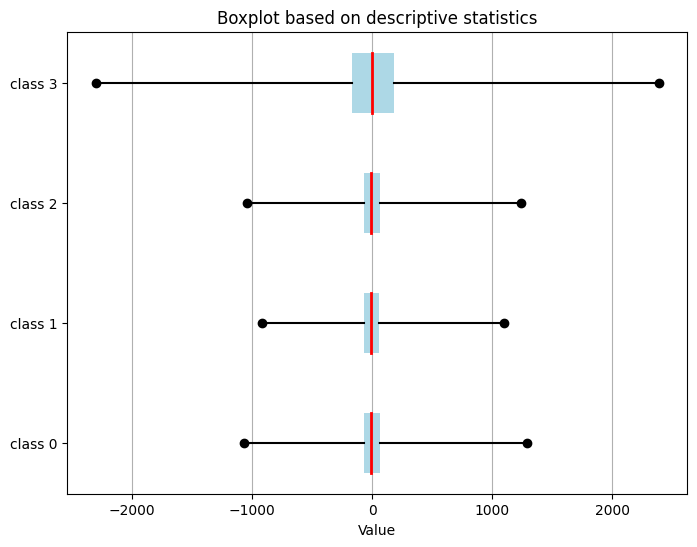

In [8]:
show_descriptive_statistics(df)

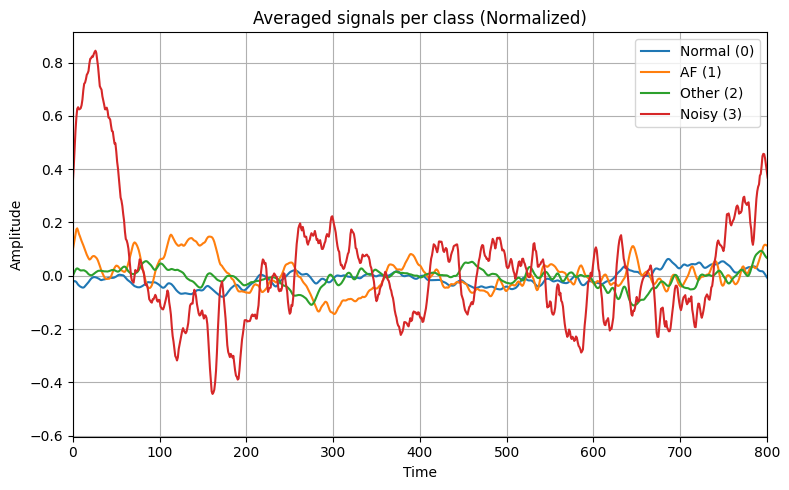

In [9]:
# plot mean signal per class
df_norm["Data"] = df_norm["Data"].apply(lambda sample: np.pad(sample, (0, max_val - sample.shape[0])))
mean_signals = [np.mean(np.stack(df_norm[df_norm["Label"] == i]["Data"].to_numpy()), axis=0) for i in range(len(all_classes))]
plt.figure(figsize=(8, 5))

for mean_signal, clss in zip(mean_signals, all_classes):
    plt.plot(mean_signal, label=clss)

plt.title("Averaged signals per class (Normalized)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, 800)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Create stratified Training and Validation Split (80/20)

In [10]:
# create training and validation split
X_train_raw, X_vald_raw, y_train_raw, y_vald_raw = train_test_split(ecg_data, labels, test_size=0.2, random_state=42, stratify=labels)

# verify that the training and validation split has same class distribution as the original dataset
raw_ratios = np.bincount(labels) / len(labels) # original dataset ratios
train_ratios = np.bincount(y_train_raw) / len(y_train_raw) # train set ratios
vald_ratios = np.bincount(y_vald_raw) / len(y_vald_raw) # validation set ratios

assert np.allclose(raw_ratios, train_ratios, atol=1e-3)
assert np.allclose(raw_ratios, vald_ratios, atol=1e-3)
assert np.allclose(train_ratios, vald_ratios, atol=1e-3)

#### Check whether training and validation sets have similar statstics to original dataset inherent

-- Class 0 --         -- Class 1 --         -- Class 2 --         -- Class 3 --         
Mean: 7.74            Mean: 9.38            Mean: 6.57            Mean: 7.49            
Std.: 205.89          Std.: 186.31          Std.: 202.97          Std.: 453.68          
Min: -1085.39         Min: -886.69          Min: -1038.48         Min: -2329.24         
Max: 1296.90          Max: 1095.88          Max: 1243.25          Max: 2401.55          
25%: -69.90           25%: -63.16           25%: -69.89           25%: -165.01          
50%: -9.97            50%: -6.57            50%: -9.04            50%: -0.49            
75%: 63.95            75%: 58.70            75%: 62.72            75%: 183.76           


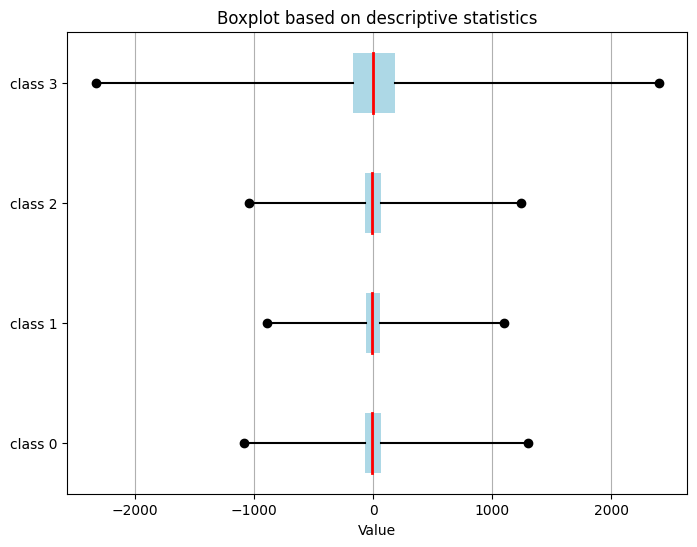

In [11]:
df_train = pd.DataFrame({"Data": X_train_raw, "Label": y_train_raw})
show_descriptive_statistics(df_train)

-- Class 0 --         -- Class 1 --         -- Class 2 --         -- Class 3 --         
Mean: 6.96            Mean: 7.02            Mean: 8.25            Mean: -3.67           
Std.: 201.81          Std.: 188.59          Std.: 209.91          Std.: 429.98          
Min: -1006.81         Min: -1022.23         Min: -1059.40         Min: -2203.80         
Max: 1258.83          Max: 1109.68          Max: 1240.91          Max: 2354.44          
25%: -69.41           25%: -65.80           25%: -72.96           25%: -156.54          
50%: -9.83            50%: -9.07            50%: -9.51            50%: -0.62            
75%: 64.27            75%: 59.57            75%: 65.70            75%: 162.36           


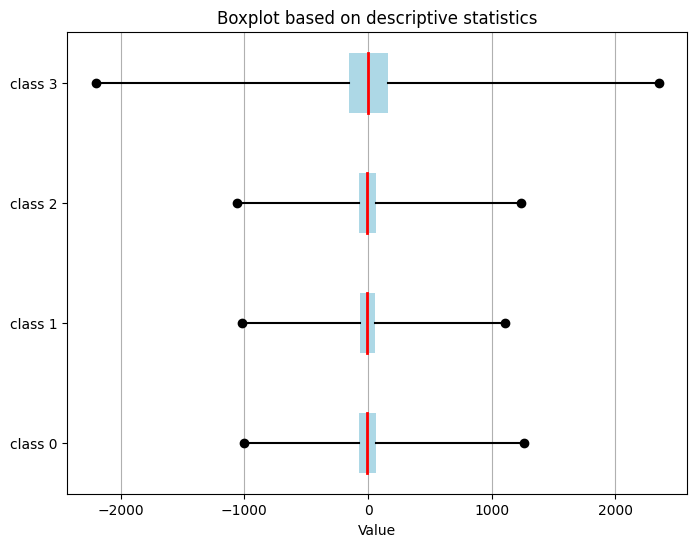

In [12]:
df_vald = pd.DataFrame({"Data": X_vald_raw, "Label": y_vald_raw})
show_descriptive_statistics(df_vald)

## Task 1.2 - Modeling and Tuning

### Model 1 (Neural Network):

#### Define model architecture

In [13]:
class CNNLSTM(nn.Module):
    def __init__(
            self, 
            channels: list[int], 
            kernel_sizes: list[int], 
            input_size: int,
            hidden_size: int, 
            num_layers: int,
            num_classes: int,
            bidirectional: bool,  
            n_fft: int = 256, 
            hop_length: int = 128
    ):
        super(CNNLSTM, self).__init__()
        assert len(channels) == len(kernel_sizes)

        # Conv2d --> BatchNorm2d --> ReLu --> MaxPool2d
        # define CNN model (Conv2d) to extract local patterns in sequences
        self.cnn = nn.Sequential()
        for idx in range(len(channels)):
            in_channels = 1 if idx == 0 else channels[idx - 1]
            out_channels = channels[idx]
            self.cnn.add_module(
                f"conv{idx}", 
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=kernel_sizes[idx], stride=1, padding=0
                )
            )
            self.cnn.add_module(f"bn{idx}", nn.BatchNorm2d(channels[idx]))
            self.cnn.add_module(f"relu{idx}", nn.ReLU())
            self.cnn.add_module(f"max_pool{idx}", nn.MaxPool2d(2))

        self.n_fft = n_fft
        self.hop_length = hop_length

        # define LSTM model to extract global patterns in sequences
        height = (n_fft // 2) + 1
        for kernel_size in kernel_sizes:
            height = math.floor(height - kernel_size) + 1 # conv-layer
            height = math.floor((height - 2) / 2) + 1 # maxpool-layer

        # reduction layer
        reduce_input_size = channels[-1] * height
        self.reduce_dim = nn.Linear(reduce_input_size, input_size)
        
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=bidirectional
        )
        
        directions = 2 if bidirectional else 1
        hidden_size *= directions
        self.fc = nn.Linear(hidden_size , num_classes)
    
    def forward(self, x: torch.Tensor):
        
        # feature extraction
        window = torch.hann_window(self.n_fft).to(x.device)
        x = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, window=window, return_complex=True).abs()
        # apply cnn model
        x = x.unsqueeze(dim=1)
        x = self.cnn(x) # output-shape: [64, 64, 62, 33] (batch_size, channels, freq_bins, time_bins)

        # prepare data for rnn
        x = x.view(x.size(0), -1, x.size(3))
        x = x.permute(0, 2, 1)

        # reduce dimension
        x = self.reduce_dim(x)

        # apply lstm model
        _, (hn, cn) = self.rnn(x)
        if self.bidirectional:
            final_hn = torch.cat((hn[-2], hn[-1]), dim=1) # consider forward and backward direction
        else:
            final_hn = hn[-1]

        x = self.fc(final_hn)
        return x


#### Define training and validation routine

In [14]:
def train(
        model: nn.Module, 
        device: torch.device, 
        train_loader: torch.utils.data.DataLoader, 
        criterion: nn.Module,
        optimizer: optim.Optimizer, 
        epoch: int
):
    model.train()
    train_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        # forward pass
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # backward pass
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.cross_entropy(output, target, reduction="sum").item()
        
        if batch_idx % 10 == 0:
            data_processed = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = (100. * batch_idx) / len(train_loader)
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed, total_data, progress, loss.item()
            ), end="\r")
    
    train_loss /= len(train_loader.dataset)
    return train_loss

def validate(
        model: nn.Module, 
        device: torch.device, 
        vald_loader: torch.utils.data.DataLoader,
        epoch: int
):
    model.eval()
    vald_loss = 0.
    correct = 0
    correct_per_class = torch.zeros(4)
    labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(vald_loader):
            # do forward pass
            data, target = data.to(device), target.to(device)
            output = model(data)
            vald_loss += F.cross_entropy(output, target, reduction='sum').item()
            # compute correct predictions
            preds = output.argmax(dim=1, keepdim=False)
            mask = preds == target
            correct_preds = torch.count_nonzero(mask).item()
            correct += correct_preds
            for t, m in zip(target, mask):
                if m: correct_per_class[t] += 1
            labels += target

    total_data = len(vald_loader.dataset)
    vald_loss /= total_data
    progress = (100. * correct)  / len(vald_loader.dataset)
    
    print("Validation Set (Epoch {}):\tAverage Loss {:.4f}\tAccuracy: {}/{} ({:.0f}%)\n".format(
        epoch, vald_loss, correct, total_data, progress
    ), end="\r")

    samples_per_class = torch.bincount(torch.tensor(labels))
    corr0, total0 = correct_per_class[0], samples_per_class[0]
    perc0 = (100. * corr0) / total0
    corr1, total1 = correct_per_class[1], samples_per_class[1]
    perc1 = (100. * corr1) / total1
    corr2, total2 = correct_per_class[2], samples_per_class[2]
    perc2 = (100. * corr2) / total2
    corr3, total3 = correct_per_class[3], samples_per_class[3]
    perc3 = (100. * corr3) / total3
    print("Class 0: {:.0f}/{} ({:.0f}%) \t Class 1: {:.0f}/{} ({:.0f}%) \t Class 2: {:.0f}/{} ({:.0f}%) \t Class 3: {:.0f}/{} ({:.0f}%)\n".format(
        corr0, total0, perc0, corr1, total1, perc1, corr2, total2, perc2, corr3, total3, perc3
    ))
    
    return vald_loss

In [15]:
def train_model(
    model: nn.Module, 
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    vald_loader: torch.utils.data.DataLoader,
    train_fn: callable,
    vald_fn: callable,
    criterion: nn.Module,
    lr=0.001, 
    weight_decay=0.0001,
    step_size=10, 
    gamma=0.1, 
    epochs=10,
    **additional_params
):
    train_params = additional_params.pop("train_params", {})
    vald_params = additional_params.pop("vald_params", {})
    
    train_losses, vald_losses = [], []
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in range(1, epochs + 1):
        train_loss = train_fn(model, device, train_loader, criterion, optimizer, epoch, **train_params)
        vald_loss = vald_fn(model, device, vald_loader, epoch, **vald_params)
        train_losses.append(train_loss)
        vald_losses.append(vald_loss)
        scheduler.step()

    return train_losses, vald_losses

#### Train Neural Network

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights =  compute_class_weight("balanced", classes=np.unique(labels), y=labels)

In [ ]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_raw, y_train_raw)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 0.9767	Accuracy: 724/1236 (59%)
Class 0: 626/728 (86%) 	 Class 1: 46/110 (42%) 	 Class 2: 13/353 (4%) 	 Class 3: 39/45 (87%)

Validation Set (Epoch 2):	Average Loss 1.0671	Accuracy: 640/1236 (52%)
Class 0: 419/728 (58%) 	 Class 1: 88/110 (80%) 	 Class 2: 98/353 (28%) 	 Class 3: 35/45 (78%)

Validation Set (Epoch 3):	Average Loss 1.1155	Accuracy: 668/1236 (54%)
Class 0: 475/728 (65%) 	 Class 1: 35/110 (32%) 	 Class 2: 113/353 (32%) 	 Class 3: 45/45 (100%)

Validation Set (Epoch 4):	Average Loss 1.0955	Accuracy: 684/1236 (55%)
Class 0: 411/728 (56%) 	 Class 1: 81/110 (74%) 	 Class 2: 148/353 (42%) 	 Class 3: 44/45 (98%)

Validation Set (Epoch 5):	Average Loss 0.7251	Accuracy: 886/1236 (72%)
Class 0: 642/728 (88%) 	 Class 1: 56/110 (51%) 	 Class 2: 154/353 (44%) 	 Class 3: 34/45 (76%)

Validation Set (Epoch 6):	Average Loss 0.7461	Accuracy: 868/1236 (70%)
Class 0: 588/728 (81%) 	 Class 1: 79/110 (72%) 	 Cl

#### Visualize Train and Test Loss

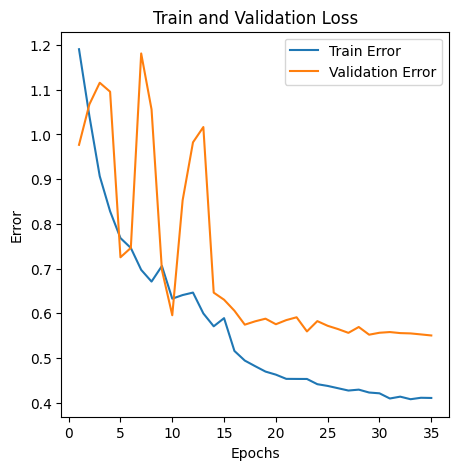

In [23]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_100")

#### Evaluate model on train set

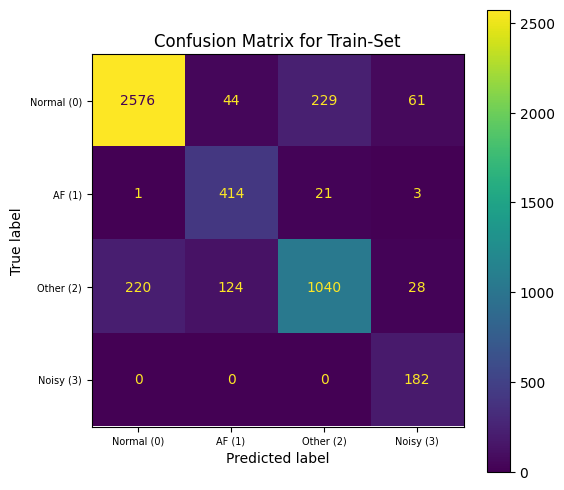


               precision  recall  f1-score  support
0                  0.92    0.89      0.90  2910.00
1                  0.71    0.94      0.81   439.00
2                  0.81    0.74      0.77  1412.00
3                  0.66    1.00      0.80   182.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.78    0.89      0.82  4943.00
weighted avg       0.86    0.85      0.85  4943.00


In [25]:
cf_report = evaluate_model(
    tsmodel,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_100.json")


#### Evaluate model on validation set

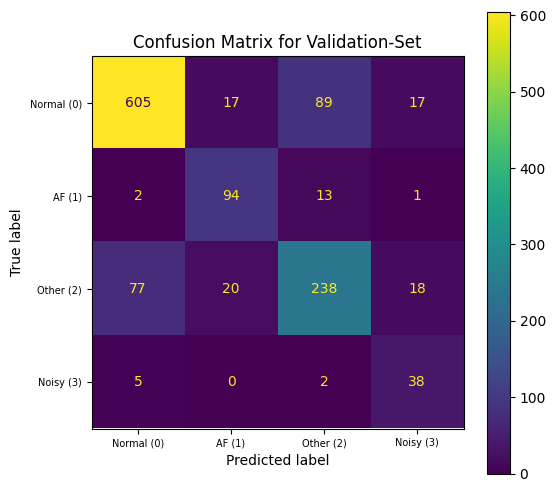


               precision  recall  f1-score  support
0                  0.88    0.83      0.85   728.00
1                  0.72    0.85      0.78   110.00
2                  0.70    0.67      0.68   353.00
3                  0.51    0.84      0.64    45.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.70    0.80      0.74  1236.00
weighted avg       0.80    0.79      0.79  1236.00


In [27]:
cf_report = evaluate_model(
    tsmodel,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_100.json")

#### Use trained model for inference (generate **base.csv**)

In [30]:
# load test dataset
test_ecg_data = load_data(root + "/data/X_test.bin", "rb")
inference_dataset = TimeSeriesDataset(test_ecg_data)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size)

In [31]:
# save inferred labels to csv file
file_name = "base.csv"
save_inferred_labels(
    tsmodel,
    inference_loader,
    device, 
    file_name
)

base.csv successfully generated


### Model 2 (Random Forest):
#### Define pipeline:
- Feature extraction using stft
- define model and train model
- evaluate model

In [33]:
### ---------------------------------------- ###
### 1. Process raw data and extract features ###
### ---------------------------------------- ###

def extract_features(
    X: list[np.array],
    interp_len = 9000,
    n_fft=1024,
    hop_length=128
):
    features = []
    for x in X:
        signal = resample_signal(x.copy(), interp_len, dtype=torch.float32)
        hann_window = torch.hann_window(n_fft)
        spectrogram = torch.stft(
            signal, 
            n_fft=n_fft, 
            hop_length=hop_length, 
            window=hann_window,
            return_complex=True
        )
        amplitude = spectrogram.abs()
        mean = amplitude.mean(dim=1)
        std = amplitude.std(dim=1)
        feature = torch.cat([mean, std], dim=0).numpy()
        features.append(feature)
    
    return np.array(features)

X_train_features = extract_features(X_train_raw)
X_vald_features = extract_features(X_vald_raw)


### ------------------------- ###
### 2. Define and train model ###
### ------------------------- ###

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_features, y_train_raw)


### --------------------------------------------- ###
### 3. Evaluate model on train and validation set ###
### --------------------------------------------- ###

,n_estimators,100
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Evaluate model on train set

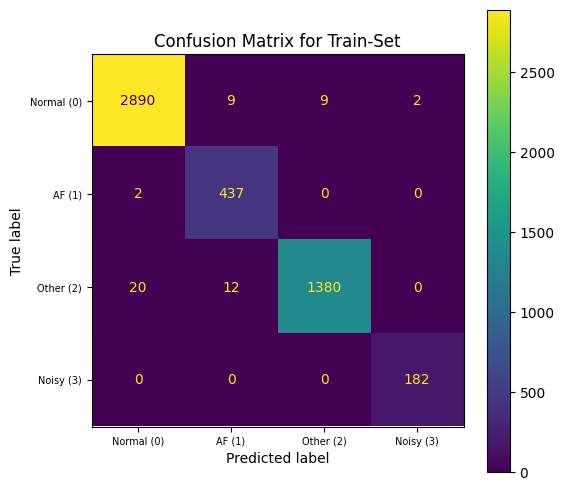


               precision  recall  f1-score  support
0                  0.99    0.99      0.99  2910.00
1                  0.95    1.00      0.97   439.00
2                  0.99    0.98      0.99  1412.00
3                  0.99    1.00      0.99   182.00
accuracy           0.99    0.99      0.99     0.99
macro avg          0.98    0.99      0.99  4943.00
weighted avg       0.99    0.99      0.99  4943.00


In [37]:
y_pred = rf.predict(X_train_features)
cf_report = show_metrics(y_train_raw, y_pred, all_classes, return_cf_report=True)
save_cf_report(cf_report, "rf_train.json")

#### Evaluate model on validation set

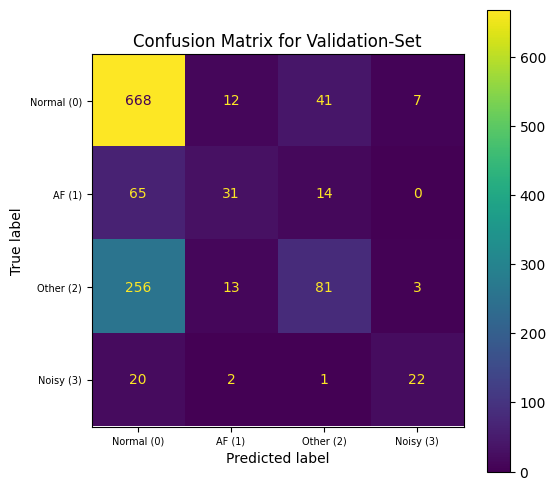


               precision  recall  f1-score  support
0                  0.66    0.92      0.77   728.00
1                  0.53    0.28      0.37   110.00
2                  0.59    0.23      0.33   353.00
3                  0.69    0.49      0.57    45.00
accuracy           0.65    0.65      0.65     0.65
macro avg          0.62    0.48      0.51  1236.00
weighted avg       0.63    0.65      0.60  1236.00


In [41]:
y_pred = rf.predict(X_vald_features)
cf_report = show_metrics(y_vald_raw, y_pred, all_classes, dataset="Validation", return_cf_report=True)
save_cf_report(cf_report, "rf_vald.json")

## Task 1.3 - Data Augmentation and Feature Engineering

In [44]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_raw, y_train_raw, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 0.9167	Accuracy: 777/1236 (63%)
Class 0: 608/728 (84%) 	 Class 1: 57/110 (52%) 	 Class 2: 85/353 (24%) 	 Class 3: 27/45 (60%)

Validation Set (Epoch 2):	Average Loss 0.8325	Accuracy: 787/1236 (64%)
Class 0: 503/728 (69%) 	 Class 1: 73/110 (66%) 	 Class 2: 174/353 (49%) 	 Class 3: 37/45 (82%)

Validation Set (Epoch 3):	Average Loss 0.7172	Accuracy: 870/1236 (70%)
Class 0: 611/728 (84%) 	 Class 1: 76/110 (69%) 	 Class 2: 141/353 (40%) 	 Class 3: 42/45 (93%)

Validation Set (Epoch 4):	Average Loss 0.7557	Accuracy: 835/1236 (68%)
Class 0: 651/728 (89%) 	 Class 1: 32/110 (29%) 	 Class 2: 109/353 (31%) 	 Class 3: 43/45 (96%)

Validation Set (Epoch 5):	Average Loss 0.7017	Accuracy: 896/1236 (72%)
Class 0: 580/728 (80%) 	 Class 1: 56/110 (51%) 	 Class 2: 218/353 (62%) 	 Class 3: 42/45 (93%)

Validation Set (Epoch 6):	Average Loss 0.6962	Accuracy: 892/1236 (72%)
Class 0: 551/728 (76%) 	 Class 1: 85/110 (77%) 	 C

#### Visualize Train and Test Loss

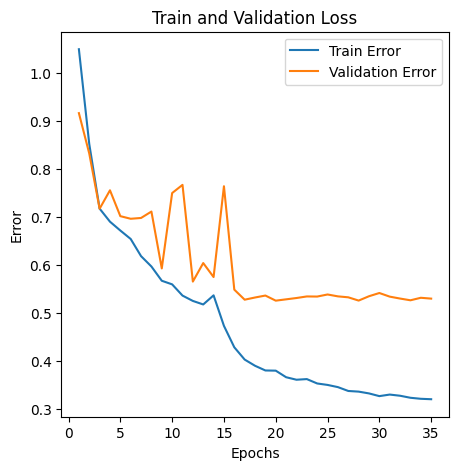

In [45]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_100")

#### Evaluate model on train set

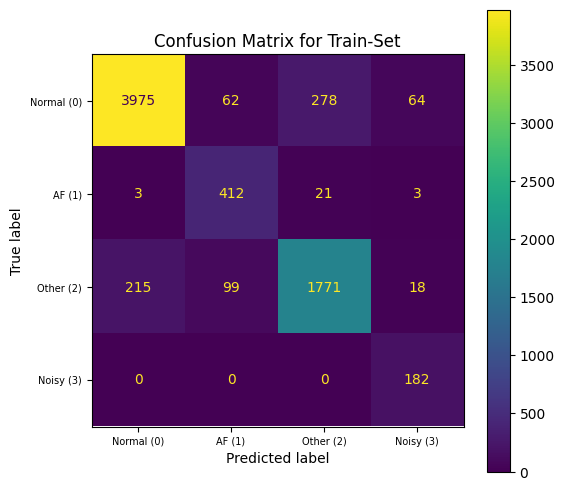


               precision  recall  f1-score  support
0                  0.95    0.91      0.93  4379.00
1                  0.72    0.94      0.81   439.00
2                  0.86    0.84      0.85  2103.00
3                  0.68    1.00      0.81   182.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.80    0.92      0.85  7103.00
weighted avg       0.90    0.89      0.89  7103.00


In [46]:
cf_report = evaluate_model(
    tsmodel_aug,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_100.json")

#### Evaluate model on validation set

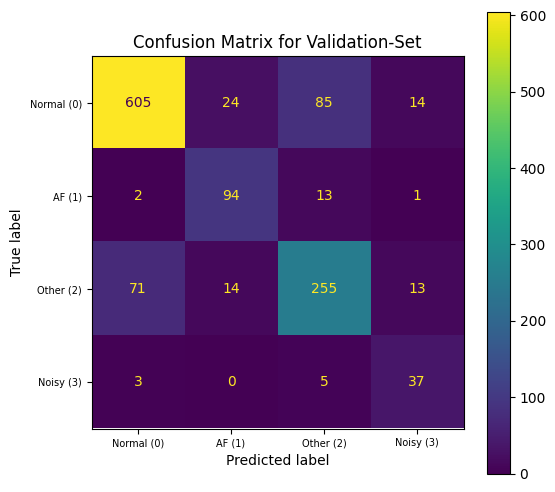


               precision  recall  f1-score  support
0                  0.89    0.83      0.86    728.0
1                  0.71    0.85      0.78    110.0
2                  0.71    0.72      0.72    353.0
3                  0.57    0.82      0.67     45.0
accuracy           0.80    0.80      0.80      0.8
macro avg          0.72    0.81      0.76   1236.0
weighted avg       0.81    0.80      0.80   1236.0


In [48]:
cf_report = evaluate_model(
    tsmodel_aug,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_100.json")

#### Use trained model for inference (generate **augment.csv**)

In [50]:
# save inferred labels to csv file
file_name = "augment.csv"
save_inferred_labels(
    tsmodel_aug,
    inference_loader,
    device, 
    file_name
)

augment.csv successfully generated


## Task 1.4 - Data Reduction

### **All data reduction is done for the original training split (*X_train_raw* - 80% of complete data). In order to make the the models fair and the results comparable, all trained models are evaluated on the same original validation split (*X_vald_raw*)**

### Compress train split to 50%, 25% and 10% of original size with PCA and save to filesystem

In [13]:
write_binary_to("X_train_lossy_50.bin", compress_ecg_data(X_train_raw, compress_to=0.5, dtype=np.int16))
write_binary_to("X_train_lossy_25.bin", compress_ecg_data(X_train_raw, compress_to=0.25, dtype=np.int16))
write_binary_to("X_train_lossy_10.bin", compress_ecg_data(X_train_raw, compress_to=0.1, dtype=np.int16))

Data successfully compressed to 50% of original size
Data successfully compressed to 25% of original size
Data successfully compressed to 10% of original size


### Plot compression results

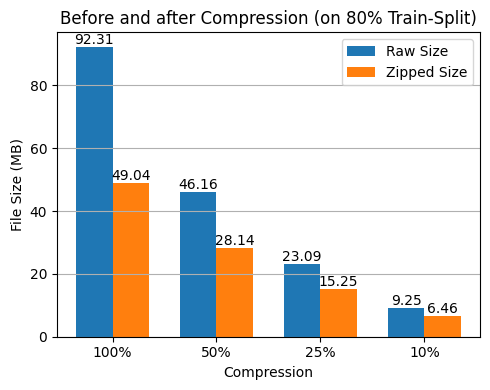

In [14]:
write_binary_to("X_train_orig_100.bin", [sig.astype(np.int16) for sig in X_train_raw])

# compute file sizes
file_paths = [
    "compressed/X_train_orig_100",
    "compressed/X_train_lossy_50",
    "compressed/X_train_lossy_25",
    "compressed/X_train_lossy_10"
]

to_mb = 1024 * 1024
raw_sizes = []
zipped_sizes = []

for file_path in file_paths:
    # compute raw size
    raw_size = round(os.path.getsize(f"{file_path}.bin") / to_mb, 2)
    raw_sizes.append(raw_size)
    # compute zipped size
    with zipfile.ZipFile(f"{file_path}.zip", "w", compression=zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(f"{file_path}.bin")
        zipped_size = round(os.path.getsize(f"{file_path}.zip") / to_mb, 2)
        zipped_sizes.append(zipped_size)
    # delete zipped versions
    os.remove(f"{file_path}.zip")

# delete original split from the beginning
os.remove("compressed/X_train_orig_100.bin")

data_sizes = ["100%", "50%", "25%", "10%"]
x = np.arange(len(data_sizes))

width = 0.35
plt.figure(figsize=(5, 4))
bars1 = plt.bar(x - width/2, raw_sizes, width, label="Raw Size")
bars2 = plt.bar(x + width/2, zipped_sizes, width, label="Zipped Size")

plt.xticks(x, data_sizes)
plt.xlabel("Compression")
plt.ylabel("File Size (MB)")
plt.title("Before and after Compression (on 80% Train-Split)")
plt.grid("True", axis="y")
plt.legend()
plt.tight_layout()

for bar1, bar2 in zip(bars1, bars2):
    height = bar1.get_height()
    plt.text(
        bar1.get_x() + bar1.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
    height = bar2.get_height()
    plt.text(
        bar2.get_x() + bar2.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
    
plt.show()

### Note: Since the compressed data is saved in the same format as the provided training/test data, so we can use our parser from the first task to load the compressed data

In [15]:
# this compressed datasets will be used for training the according models
X_train_lossy_50 = load_data("compressed/X_train_lossy_50.bin", "rb")
X_train_lossy_25 = load_data("compressed/X_train_lossy_25.bin", "rb")
X_train_lossy_10 = load_data("compressed/X_train_lossy_10.bin", "rb")

### Compute MAE and MSE for original and compressed data

In [67]:
mae50, mse50 = compute_compression_metrics(X_train_raw, X_train_lossy_50, compr_size=0.5)
mae25, mse25 = compute_compression_metrics(X_train_raw, X_train_lossy_25, compr_size=0.25)
mae10, mse10 = compute_compression_metrics(X_train_raw, X_train_lossy_10, compr_size=0.1)

MAE's: [6.57511, 13.04183, 30.90046]
MSE's: [353.34198, 1630.84863, 7498.34432]


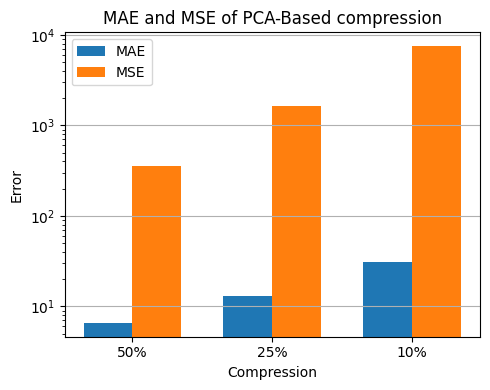

In [69]:
data_sizes = ["50%", "25%", "10%"]
maes = [mae50, mae25, mae10]
mses = [mse50, mse25, mse10]
print(f"MAE's: {maes}")
print(f"MSE's: {mses}")

x = np.arange(len(data_sizes))
width = 0.35
plt.figure(figsize=(5, 4))
plt.bar(x - width/2, maes, width, label="MAE")
plt.bar(x + width/2, mses, width, label="MSE")

plt.xticks(x, data_sizes)
plt.xlabel("Compression")
plt.ylabel("Error")
plt.yscale("log")
plt.title("MAE and MSE of PCA-Based compression")
plt.grid("True", axis="y")
plt.legend()
plt.tight_layout()
plt.show()


### Train augmented model from Task 1.3 with compressed training data

#### Train model with 50% training data and evaluate it

In [90]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug_50 = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_lossy_50, y_train_raw, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug_50,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 0.9356	Accuracy: 749/1236 (61%)
Class 0: 646/728 (89%) 	 Class 1: 21/110 (19%) 	 Class 2: 48/353 (14%) 	 Class 3: 34/45 (76%)

Validation Set (Epoch 2):	Average Loss 1.0414	Accuracy: 637/1236 (52%)
Class 0: 368/728 (51%) 	 Class 1: 65/110 (59%) 	 Class 2: 167/353 (47%) 	 Class 3: 37/45 (82%)

Validation Set (Epoch 3):	Average Loss 0.7465	Accuracy: 868/1236 (70%)
Class 0: 646/728 (89%) 	 Class 1: 45/110 (41%) 	 Class 2: 139/353 (39%) 	 Class 3: 38/45 (84%)

Validation Set (Epoch 4):	Average Loss 0.6986	Accuracy: 892/1236 (72%)
Class 0: 626/728 (86%) 	 Class 1: 37/110 (34%) 	 Class 2: 189/353 (54%) 	 Class 3: 40/45 (89%)

Validation Set (Epoch 5):	Average Loss 0.6485	Accuracy: 888/1236 (72%)
Class 0: 634/728 (87%) 	 Class 1: 46/110 (42%) 	 Class 2: 174/353 (49%) 	 Class 3: 34/45 (76%)

Validation Set (Epoch 6):	Average Loss 0.7872	Accuracy: 830/1236 (67%)
Class 0: 512/728 (70%) 	 Class 1: 85/110 (77%) 	 C

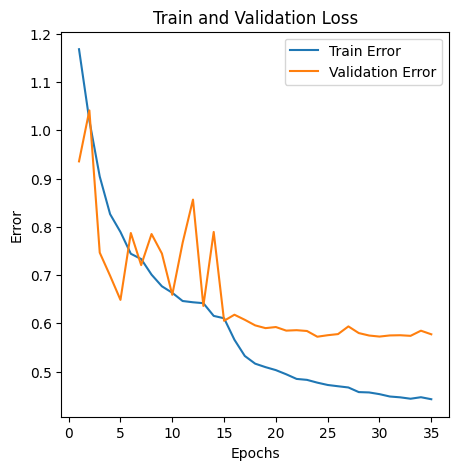

In [92]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_50")

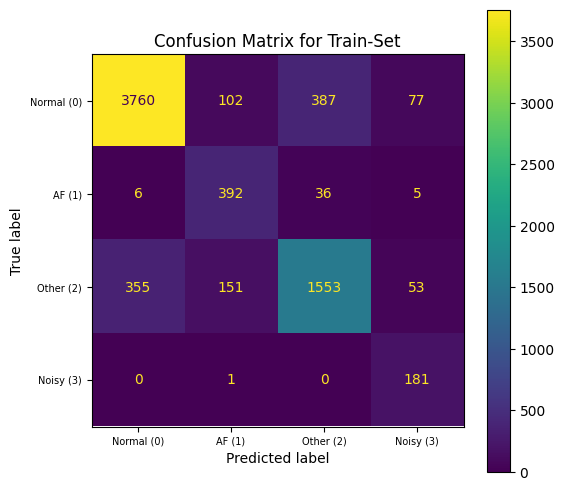


               precision  recall  f1-score  support
0                  0.91    0.87      0.89  4326.00
1                  0.61    0.89      0.72   439.00
2                  0.79    0.74      0.76  2112.00
3                  0.57    0.99      0.73   182.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.72    0.87      0.77  7059.00
weighted avg       0.85    0.83      0.84  7059.00


In [94]:
cf_report = evaluate_model(
    tsmodel_aug_50,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_50.json")

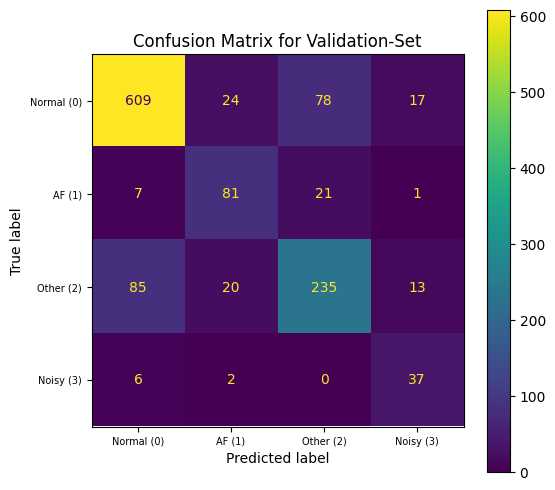


               precision  recall  f1-score  support
0                  0.86    0.84      0.85   728.00
1                  0.64    0.74      0.68   110.00
2                  0.70    0.67      0.68   353.00
3                  0.54    0.82      0.65    45.00
accuracy           0.78    0.78      0.78     0.78
macro avg          0.69    0.77      0.72  1236.00
weighted avg       0.78    0.78      0.78  1236.00


In [95]:
cf_report = evaluate_model(
    tsmodel_aug_50,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_50.json")

#### Train model with 25% training data and evaluate it

In [96]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug_25 = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_lossy_25, y_train_raw, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug_25,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 0.9600	Accuracy: 741/1236 (60%)
Class 0: 666/728 (91%) 	 Class 1: 39/110 (35%) 	 Class 2: 12/353 (3%) 	 Class 3: 24/45 (53%)

Validation Set (Epoch 2):	Average Loss 0.9687	Accuracy: 718/1236 (58%)
Class 0: 585/728 (80%) 	 Class 1: 64/110 (58%) 	 Class 2: 27/353 (8%) 	 Class 3: 42/45 (93%)

Validation Set (Epoch 3):	Average Loss 0.7959	Accuracy: 805/1236 (65%)
Class 0: 658/728 (90%) 	 Class 1: 35/110 (32%) 	 Class 2: 83/353 (24%) 	 Class 3: 29/45 (64%)

Validation Set (Epoch 4):	Average Loss 0.8075	Accuracy: 832/1236 (67%)
Class 0: 603/728 (83%) 	 Class 1: 70/110 (64%) 	 Class 2: 117/353 (33%) 	 Class 3: 42/45 (93%)

Validation Set (Epoch 5):	Average Loss 0.7551	Accuracy: 826/1236 (67%)
Class 0: 570/728 (78%) 	 Class 1: 65/110 (59%) 	 Class 2: 155/353 (44%) 	 Class 3: 36/45 (80%)

Validation Set (Epoch 6):	Average Loss 0.6945	Accuracy: 891/1236 (72%)
Class 0: 606/728 (83%) 	 Class 1: 63/110 (57%) 	 Class

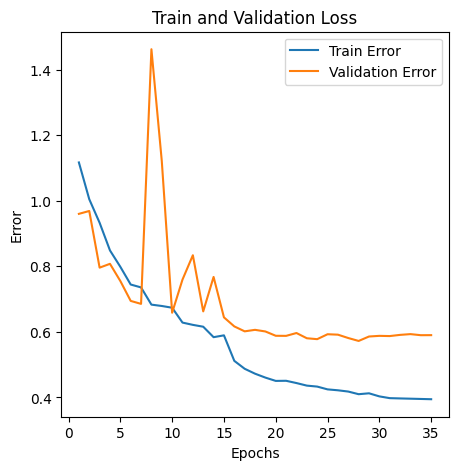

In [98]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_25")

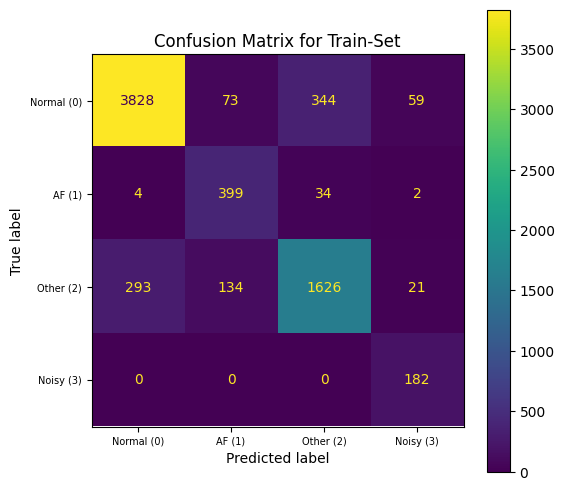


               precision  recall  f1-score  support
0                  0.93    0.89      0.91  4304.00
1                  0.66    0.91      0.76   439.00
2                  0.81    0.78      0.80  2074.00
3                  0.69    1.00      0.82   182.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.77    0.90      0.82  6999.00
weighted avg       0.87    0.86      0.86  6999.00


In [99]:
cf_report = evaluate_model(
    tsmodel_aug_25,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_25.json")

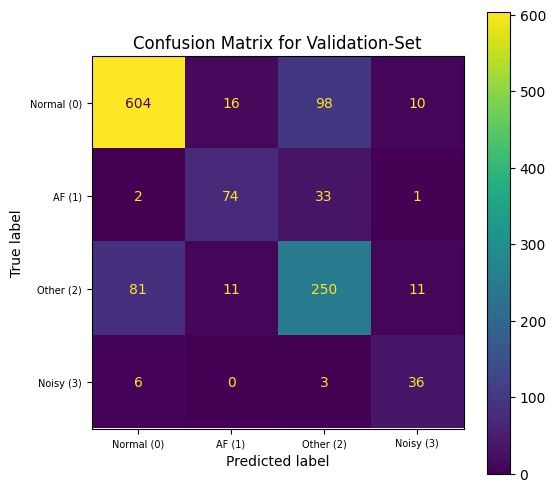


               precision  recall  f1-score  support
0                  0.87    0.83      0.85   728.00
1                  0.73    0.67      0.70   110.00
2                  0.65    0.71      0.68   353.00
3                  0.62    0.80      0.70    45.00
accuracy           0.78    0.78      0.78     0.78
macro avg          0.72    0.75      0.73  1236.00
weighted avg       0.79    0.78      0.78  1236.00


In [100]:
cf_report = evaluate_model(
    tsmodel_aug_25,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_25.json")

#### Train model with 10% training data and evaluate it

In [122]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug_10 = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_lossy_10, y_train_raw, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug_10,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 1.0757	Accuracy: 434/1236 (35%)
Class 0: 145/728 (20%) 	 Class 1: 0/110 (0%) 	 Class 2: 276/353 (78%) 	 Class 3: 13/45 (29%)

Validation Set (Epoch 2):	Average Loss 0.9056	Accuracy: 757/1236 (61%)
Class 0: 706/728 (97%) 	 Class 1: 0/110 (0%) 	 Class 2: 32/353 (9%) 	 Class 3: 19/45 (42%)

Validation Set (Epoch 3):	Average Loss 0.9745	Accuracy: 708/1236 (57%)
Class 0: 454/728 (62%) 	 Class 1: 0/110 (0%) 	 Class 2: 221/353 (63%) 	 Class 3: 33/45 (73%)

Validation Set (Epoch 4):	Average Loss 0.9372	Accuracy: 771/1236 (62%)
Class 0: 619/728 (85%) 	 Class 1: 4/110 (4%) 	 Class 2: 134/353 (38%) 	 Class 3: 14/45 (31%)

Validation Set (Epoch 5):	Average Loss 0.8804	Accuracy: 786/1236 (64%)
Class 0: 564/728 (77%) 	 Class 1: 7/110 (6%) 	 Class 2: 181/353 (51%) 	 Class 3: 34/45 (76%)

Validation Set (Epoch 6):	Average Loss 0.9294	Accuracy: 701/1236 (57%)
Class 0: 429/728 (59%) 	 Class 1: 9/110 (8%) 	 Class 2: 238/3

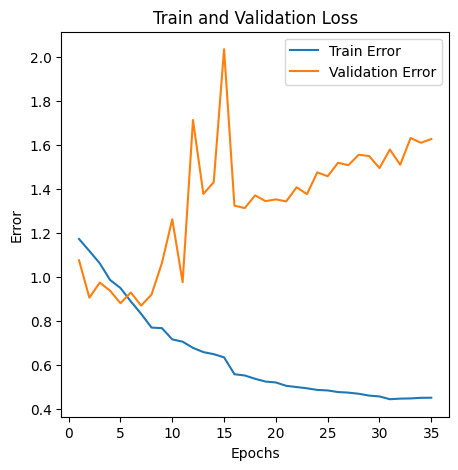

In [124]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_10")

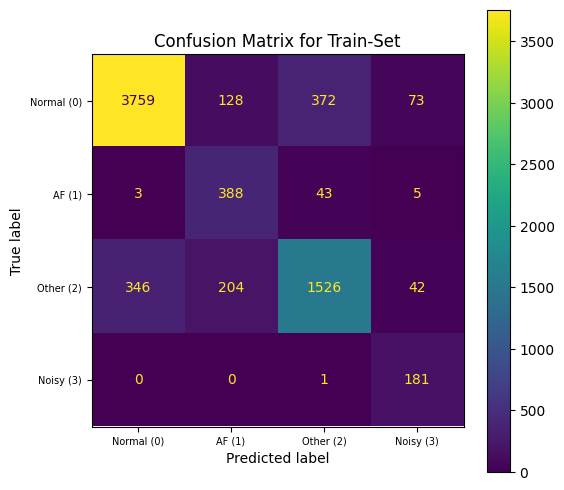


               precision  recall  f1-score  support
0                  0.92    0.87      0.89  4332.00
1                  0.54    0.88      0.67   439.00
2                  0.79    0.72      0.75  2118.00
3                  0.60    0.99      0.75   182.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.71    0.87      0.77  7071.00
weighted avg       0.84    0.83      0.83  7071.00


In [127]:
cf_report = evaluate_model(
    tsmodel_aug_10,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_10.json")

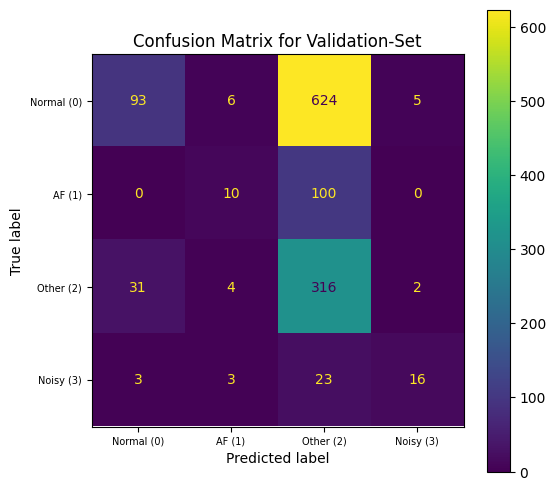


               precision  recall  f1-score  support
0                  0.73    0.13      0.22   728.00
1                  0.43    0.09      0.15   110.00
2                  0.30    0.90      0.45   353.00
3                  0.70    0.36      0.47    45.00
accuracy           0.35    0.35      0.35     0.35
macro avg          0.54    0.37      0.32  1236.00
weighted avg       0.58    0.35      0.29  1236.00


In [128]:
cf_report = evaluate_model(
    tsmodel_aug_10,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_10.json")

### Train augmented model from Task 1.3 with stratified data **for comparision with compressed data**

#### Create stratified split with 50%, 25% and 10% of original size

In [106]:
X_train_strat_50, _, y_train_strat_50, _ = train_test_split(ecg_data, labels, train_size=0.5, random_state=42, stratify=labels)
X_train_strat_25, _, y_train_strat_25, _ = train_test_split(ecg_data, labels, train_size=0.25, random_state=42, stratify=labels)
X_train_strat_10, _, y_train_strat_10, _ = train_test_split(ecg_data, labels, train_size=0.1, random_state=42, stratify=labels)

#### Train model with 50% stratified training data and evaluate it

In [107]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug_strat_50 = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_strat_50, y_train_strat_50, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug_strat_50,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 1.0372	Accuracy: 527/1236 (43%)
Class 0: 215/728 (30%) 	 Class 1: 0/110 (0%) 	 Class 2: 287/353 (81%) 	 Class 3: 25/45 (56%)

Validation Set (Epoch 2):	Average Loss 1.0947	Accuracy: 623/1236 (50%)
Class 0: 404/728 (55%) 	 Class 1: 24/110 (22%) 	 Class 2: 156/353 (44%) 	 Class 3: 39/45 (87%)

Validation Set (Epoch 3):	Average Loss 1.1543	Accuracy: 622/1236 (50%)
Class 0: 412/728 (57%) 	 Class 1: 35/110 (32%) 	 Class 2: 135/353 (38%) 	 Class 3: 40/45 (89%)

Validation Set (Epoch 4):	Average Loss 0.8528	Accuracy: 786/1236 (64%)
Class 0: 586/728 (80%) 	 Class 1: 39/110 (35%) 	 Class 2: 126/353 (36%) 	 Class 3: 35/45 (78%)

Validation Set (Epoch 5):	Average Loss 1.2316	Accuracy: 513/1236 (42%)
Class 0: 208/728 (29%) 	 Class 1: 80/110 (73%) 	 Class 2: 186/353 (53%) 	 Class 3: 39/45 (87%)

Validation Set (Epoch 6):	Average Loss 0.8317	Accuracy: 823/1236 (67%)
Class 0: 535/728 (73%) 	 Class 1: 71/110 (65%) 	 Cl

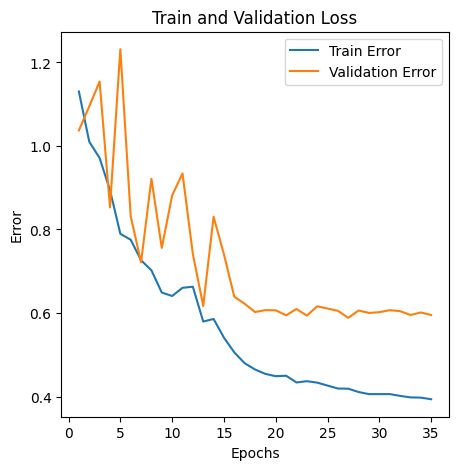

In [108]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_strat_50")

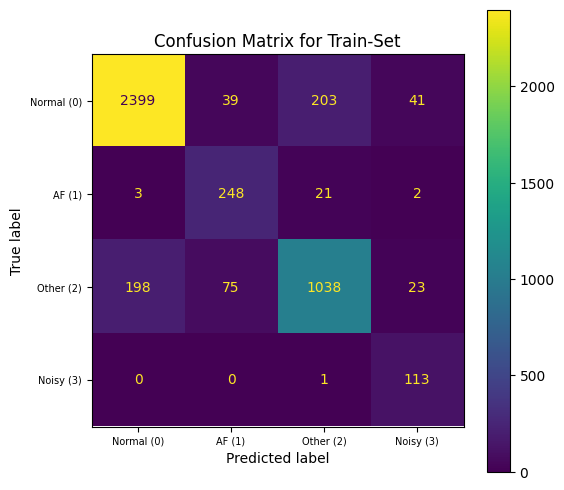


               precision  recall  f1-score  support
0                  0.92    0.89      0.91  2682.00
1                  0.69    0.91      0.78   274.00
2                  0.82    0.78      0.80  1334.00
3                  0.63    0.99      0.77   114.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.77    0.89      0.81  4404.00
weighted avg       0.87    0.86      0.86  4404.00


In [109]:
cf_report = evaluate_model(
    tsmodel_aug_strat_50,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_strat_50.json")

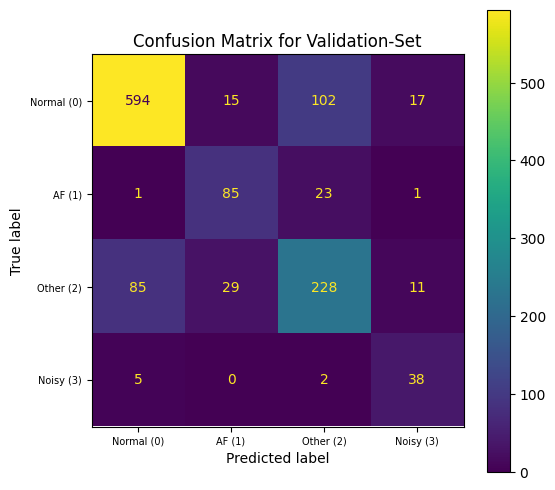


               precision  recall  f1-score  support
0                  0.87    0.82      0.84   728.00
1                  0.66    0.77      0.71   110.00
2                  0.64    0.65      0.64   353.00
3                  0.57    0.84      0.68    45.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.68    0.77      0.72  1236.00
weighted avg       0.77    0.76      0.77  1236.00


In [110]:
cf_report = evaluate_model(
    tsmodel_aug_strat_50,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_strat_50.json")

#### Train model with 25% stratified training data and evaluate it

In [111]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug_strat_25 = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_strat_25, y_train_strat_25, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug_strat_25,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 0.9678	Accuracy: 758/1236 (61%)
Class 0: 623/728 (86%) 	 Class 1: 3/110 (3%) 	 Class 2: 104/353 (29%) 	 Class 3: 28/45 (62%)

Validation Set (Epoch 2):	Average Loss 1.2041	Accuracy: 576/1236 (47%)
Class 0: 396/728 (54%) 	 Class 1: 72/110 (65%) 	 Class 2: 69/353 (20%) 	 Class 3: 39/45 (87%)

Validation Set (Epoch 3):	Average Loss 0.8830	Accuracy: 813/1236 (66%)
Class 0: 595/728 (82%) 	 Class 1: 33/110 (30%) 	 Class 2: 152/353 (43%) 	 Class 3: 33/45 (73%)

Validation Set (Epoch 4):	Average Loss 0.8800	Accuracy: 754/1236 (61%)
Class 0: 598/728 (82%) 	 Class 1: 28/110 (25%) 	 Class 2: 91/353 (26%) 	 Class 3: 37/45 (82%)

Validation Set (Epoch 5):	Average Loss 0.8348	Accuracy: 783/1236 (63%)
Class 0: 649/728 (89%) 	 Class 1: 61/110 (55%) 	 Class 2: 64/353 (18%) 	 Class 3: 9/45 (20%)

Validation Set (Epoch 6):	Average Loss 0.7386	Accuracy: 866/1236 (70%)
Class 0: 597/728 (82%) 	 Class 1: 50/110 (45%) 	 Class 

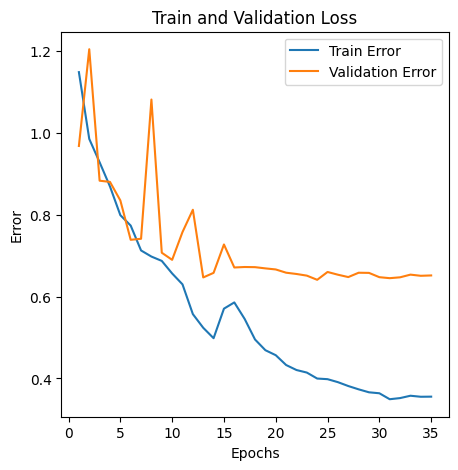

In [112]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_strat_25")

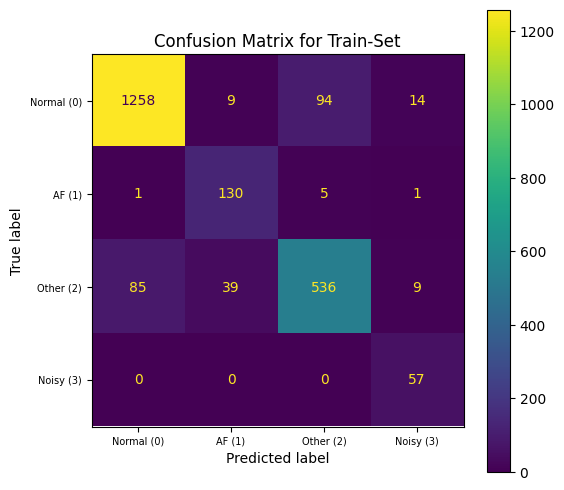


               precision  recall  f1-score  support
0                  0.94    0.91      0.93  1375.00
1                  0.73    0.95      0.83   137.00
2                  0.84    0.80      0.82   669.00
3                  0.70    1.00      0.83    57.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.80    0.92      0.85  2238.00
weighted avg       0.89    0.89      0.89  2238.00


In [113]:
cf_report = evaluate_model(
    tsmodel_aug_strat_25,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_strat_25.json")

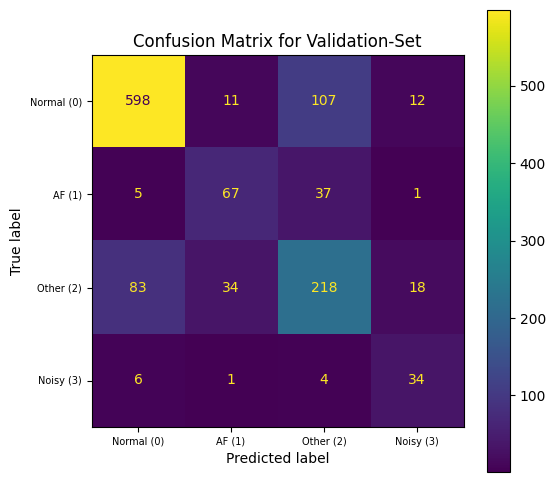


               precision  recall  f1-score  support
0                  0.86    0.82      0.84   728.00
1                  0.59    0.61      0.60   110.00
2                  0.60    0.62      0.61   353.00
3                  0.52    0.76      0.62    45.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.64    0.70      0.67  1236.00
weighted avg       0.75    0.74      0.75  1236.00


In [115]:
cf_report = evaluate_model(
    tsmodel_aug_strat_25,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_strat_25.json")

#### Train model with 10% stratified training data and evaluate it

In [116]:
print(f"Training of the model is running with: {device}\n")

# hyperparameters
batch_size = 128
epochs = 35
lr = 0.0015
step_size = 15
gamma = 0.05
# features
n_fft = 256
hop_length = 64
# cnn
channels = [32, 64]
kernel_sizes = [6, 6]
# lstm
input_size = 128
hidden_size = 192
num_layers = 1
num_classes = 4
bidirectional = False

# initialize model
tsmodel_aug_strat_10 = CNNLSTM(
    channels, kernel_sizes,
    input_size, hidden_size, num_layers, 
    num_classes, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

train_dataset = TimeSeriesDataset(X_train_strat_10, y_train_strat_10, augment=True)
vald_dataset = TimeSeriesDataset(X_vald_raw, y_vald_raw)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vald_loader = DataLoader(vald_dataset, batch_size=batch_size)

# training and validation loop
train_losses, vald_losses = train_model(
    tsmodel_aug_strat_10,
    device,
    train_loader,
    vald_loader,
    train,
    validate,
    criterion,
    epochs=epochs,
    lr=lr,
    step_size=step_size,
    gamma=gamma
)

Training of the model is running with: cuda

Validation Set (Epoch 1):	Average Loss 1.3188	Accuracy: 344/1236 (28%)
Class 0: 7/728 (1%) 	 Class 1: 0/110 (0%) 	 Class 2: 313/353 (89%) 	 Class 3: 24/45 (53%)

Validation Set (Epoch 2):	Average Loss 0.9784	Accuracy: 705/1236 (57%)
Class 0: 583/728 (80%) 	 Class 1: 2/110 (2%) 	 Class 2: 89/353 (25%) 	 Class 3: 31/45 (69%)

Validation Set (Epoch 3):	Average Loss 1.0743	Accuracy: 653/1236 (53%)
Class 0: 452/728 (62%) 	 Class 1: 54/110 (49%) 	 Class 2: 120/353 (34%) 	 Class 3: 27/45 (60%)

Validation Set (Epoch 4):	Average Loss 0.9023	Accuracy: 750/1236 (61%)
Class 0: 625/728 (86%) 	 Class 1: 38/110 (35%) 	 Class 2: 62/353 (18%) 	 Class 3: 25/45 (56%)

Validation Set (Epoch 5):	Average Loss 0.9676	Accuracy: 718/1236 (58%)
Class 0: 516/728 (71%) 	 Class 1: 38/110 (35%) 	 Class 2: 134/353 (38%) 	 Class 3: 30/45 (67%)

Validation Set (Epoch 6):	Average Loss 1.0359	Accuracy: 628/1236 (51%)
Class 0: 405/728 (56%) 	 Class 1: 27/110 (25%) 	 Class 2: 

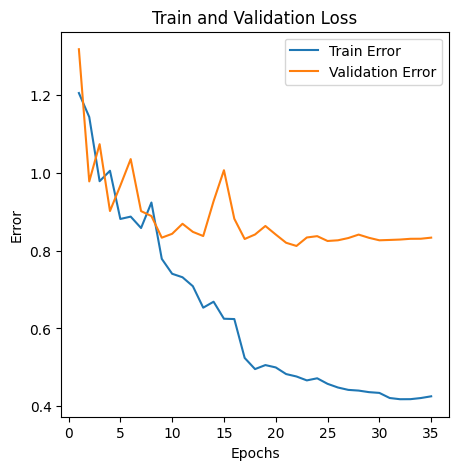

In [117]:
show_loss(
    train_losses,
    vald_losses,
    epochs
)
save_losses(train_losses, vald_losses, "model_aug_strat_10")

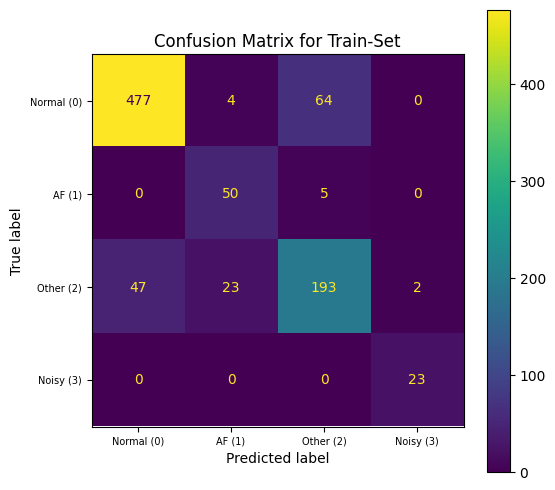


               precision  recall  f1-score  support
0                  0.91    0.88      0.89   545.00
1                  0.65    0.91      0.76    55.00
2                  0.74    0.73      0.73   265.00
3                  0.92    1.00      0.96    23.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.80    0.88      0.84   888.00
weighted avg       0.84    0.84      0.84   888.00


In [118]:
cf_report = evaluate_model(
    tsmodel_aug_strat_10,
    train_loader,
    device,
    all_classes,
    return_cf_report=True
)
save_cf_report(cf_report, "train_aug_strat_10.json")

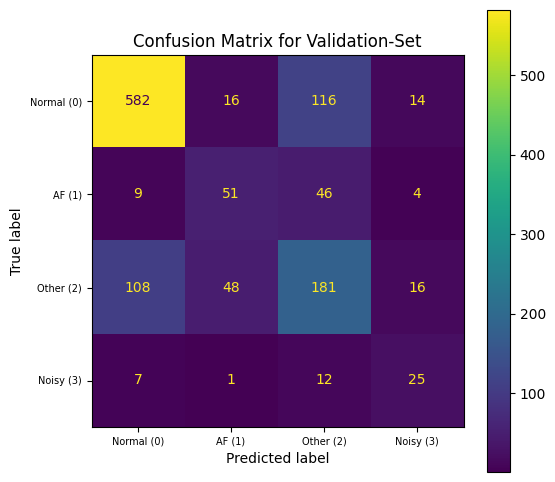


               precision  recall  f1-score  support
0                  0.82    0.80      0.81   728.00
1                  0.44    0.46      0.45   110.00
2                  0.51    0.51      0.51   353.00
3                  0.42    0.56      0.48    45.00
accuracy           0.68    0.68      0.68     0.68
macro avg          0.55    0.58      0.56  1236.00
weighted avg       0.69    0.68      0.68  1236.00


In [119]:
cf_report = evaluate_model(
    tsmodel_aug_strat_10,
    vald_loader,
    device,
    all_classes,
    dataset="Validation",
    return_cf_report=True
)
save_cf_report(cf_report, "vald_aug_strat_10.json")

#### Use trained 25% model for inference (generate **reduced.csv**)

In [120]:
# save inferred labels to csv file
file_name = "reduced.csv"
save_inferred_labels(
    tsmodel_aug_25,
    inference_loader,
    device, 
    file_name
)

reduced.csv successfully generated


### Plot final results of validation set

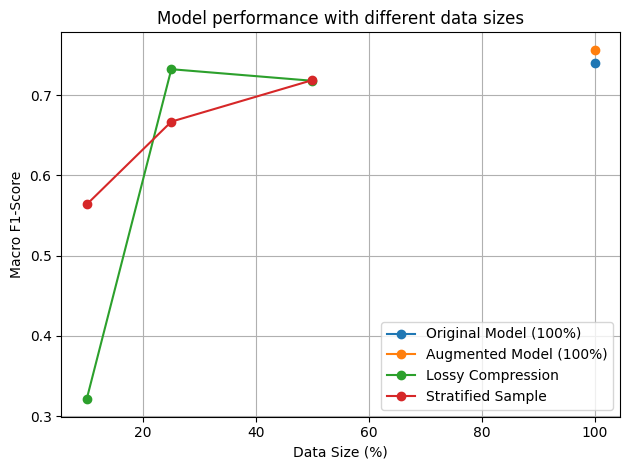

In [215]:
cf_report_100 = load_cf_report("vald_100.json")
cf_report_aug_100 = load_cf_report("vald_aug_100.json")

cf_report_aug_50 = load_cf_report("vald_aug_50.json")
cf_report_aug_25 = load_cf_report("vald_aug_25.json")
cf_report_aug_10 = load_cf_report("vald_aug_10.json")

cf_report_aug_strat_50 = load_cf_report("vald_aug_strat_50.json")
cf_report_aug_strat_25 = load_cf_report("vald_aug_strat_25.json")
cf_report_aug_strat_10 = load_cf_report("vald_aug_strat_10.json")

x= [10, 25, 50, 100]
# macro f1-scores
f1_orig = [
    None, None, None,
    cf_report_100["macro avg"]["f1-score"]
]
f1_aug = [
    None, None, None,
    cf_report_aug_100["macro avg"]["f1-score"]
]
f1_lossy = [
    cf_report_aug_10["macro avg"]["f1-score"],
    cf_report_aug_25["macro avg"]["f1-score"],
    cf_report_aug_50["macro avg"]["f1-score"],
    None
]
f1_strat = [
    cf_report_aug_strat_10["macro avg"]["f1-score"],
    cf_report_aug_strat_25["macro avg"]["f1-score"],
    cf_report_aug_strat_50["macro avg"]["f1-score"],
    None
]

plt.plot(x, f1_orig, label="Original Model (100%)", marker="o")
plt.plot(x, f1_aug, label="Augmented Model (100%)", marker="o")
plt.plot(x, f1_lossy, label="Lossy Compression", marker="o")
plt.plot(x, f1_strat, label="Stratified Sample", marker="o")

plt.xlabel("Data Size (%)")
plt.ylabel("Macro F1-Score")
plt.title("Model performance with different data sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()